Importing libraries

In [41]:
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, OneHotEncoder, StandardScaler
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import json
import matplotlib.pyplot as plt
import pandas as pd

Loading data

In [42]:
with open('steam_games.json', 'r') as f:
    data = [json.loads(line) for line in f]
df = pd.DataFrame(data)


In [43]:
df.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,f7ccb8df,"[Action, Adventure, Casual]",f39b8eba2222,f39b8eba2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,f7ccb8df,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


Discarding rows with too few Steam reviews to have a sentinment score

In [44]:
discarded_sentiments = ['1 user reviews', '2 user reviews', '3 user reviews',
                        '4 user reviews', '5 user reviews', '6 user reviews',
                        '7 user reviews', '8 user reviews', '9 user reviews']

df = df[~df['sentiment'].isin(discarded_sentiments)]

Discarding null rows because this is the target variable

In [45]:
df = df.dropna(subset='sentiment')

Converting the sentiment names to numerical values from 1-9. This is the "rating" that the neural network will learn to predict

In [46]:
sentiment_rating_mapping = {
    'Overwhelmingly Negative': 1,
    'Very Negative': 2,
    'Mostly Negative': 3,
    'Negative': 4,
    'Mixed': 5,
    'Mostly Positive': 6,
    'Positive': 7,
    'Very Positive': 8,
    'Overwhelmingly Positive': 9,
}

df['sentiment'] = df['sentiment'].map(sentiment_rating_mapping)

These features won't be used so dropping them

In [47]:
df = df.drop(['discount_price', 'url', 'reviews_url'], axis=1)

Preparing null metascore values. We will handle these null values soon

In [48]:
df['metascore'] = df['metascore'].replace('NA', float('nan'))
df['metascore'] = df['metascore'].replace(pd.NA, float('nan'))

Converting the release date feature to year, month and day_of_week features

In [49]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['year'] = df['release_date'].dt.year
df['month'] = df['release_date'].dt.month
df['day_of_week'] = df['release_date'].dt.dayofweek
df = df.drop('release_date', axis=1)

The dataset had strings like 'Free' written in the Price column in some areas. Replace all that with 0 price

In [50]:
df['price'] = df['price'].replace(to_replace=r'.*Free.*', value=0, regex=True)
df['price'] = df['price'].replace(to_replace=r'.*Play.*', value=0, regex=True)
df['price'] = df['price'].replace(to_replace=r'.*Install.*', value=0, regex=True)
df = df[df['price'] != 'Third-party']
df['price'] = df['price'].astype('float')

If the specs, tags of genres rows are null replace them with an empty list

In [51]:
df['specs'] = df['specs'].apply(lambda x: x if isinstance(x, list) else [])
df['tags'] = df['tags'].apply(lambda x: x if isinstance(x, list) else [])
df['genres'] = df['genres'].apply(lambda x: x if isinstance(x, list) else [])

Handling null values for each feature

In [52]:
df['publisher'] = df['publisher'].fillna('NA')
df['developer'] = df['developer'].fillna('NA')
df['app_name'] = df['app_name'].fillna('NA')

# Title can be inferred from app_name
df['title'] = df['title'].fillna(df['app_name'])
df['id'] = df['id'].fillna('NA')

df['early_access'] = df['early_access'].fillna(False)

df['year'] = df['year'].fillna(-1)
df['month'] = df['month'].fillna(-1)
df['day_of_week'] = df['day_of_week'].fillna(-1)


df['price'].fillna(-1, inplace=True)


Since metascore is an important feature that can tell us a lot about how good the game is, we will train a metalearner to perform Regression Imputation and predict the mising value using the other features

In [53]:
from sklearn.ensemble import RandomForestRegressor

# Select features that will be used for prediction
predictor_vars = ['price', 'sentiment', 'early_access', 'year', 'month', 'day_of_week']

# Split data into two parts
train_data = df.dropna(subset=['metascore'])
predict_data = df[df['metascore'].isnull()]

# Train a regression model
model = RandomForestRegressor(n_estimators=100)
model.fit(train_data[predictor_vars], train_data['metascore'])

# Predict the missing metascores
predicted_scores = model.predict(predict_data[predictor_vars])

# Replace the missing metascores in the original DataFrame
df.loc[df['metascore'].isnull(), 'metascore'] = predicted_scores

Splitting features into numerical and categorical columns

In [54]:
categorical_features = ['publisher', 'developer']
multi_label_features = ['specs', 'tags', 'genres']
numerical_features = ['price', 'year', 'metascore', 'month', 'day_of_week', 'early_access']

Sampling 100 random rows of the original dataset for demonstration later

In [69]:
# Split the original dataset first
df_test = df.sample(n=100)
df_test

,publisher,genres,app_name,title,tags,specs,price,early_access,id,developer,...,genres_Photo Editing,genres_RPG,genres_Racing,genres_Simulation,genres_Software Training,genres_Sports,genres_Strategy,genres_Utilities,genres_Video Production,genres_Web Publishing
14573,556,[Action],Wolfenstein II: The New Colossus,Wolfenstein II: The New Colossus,"[Action, FPS, Gore, Violent, Alternate History...","[Single-player, Steam Achievements, Full contr...",3.617664,-0.279955,612880,3815,...,0,0,0,0,0,0,0,0,0,0
30855,4982,"[Adventure, Indie]",Resonance,Resonance,"[Adventure, Point & Click, Indie, Sci-fi, Retr...","[Single-player, Steam Achievements, Steam Trad...",0.022143,-0.279955,212050,7009,...,0,0,0,0,0,0,0,0,0,0
6077,2018,"[Action, Indie]",Share,Share,"[Indie, Action, Horror]","[Single-player, Steam Trading Cards]",-0.337409,-0.279955,448020,2779,...,0,0,0,0,0,0,0,0,0,0
21537,5005,"[Action, Adventure]",Rebels Character Pack,Rebels Character Pack,"[Action, Adventure]","[Single-player, Shared/Split Screen, Downloada...",-0.553140,-0.279955,466549,6501,...,0,0,0,0,0,0,0,0,0,0
7571,4357,[Strategy],Hidden Dimensions 3,Hidden Dimensions 3,"[Strategy, Free to Play, Card Game, Indie]",[Single-player],-0.696242,-0.279955,531540,5948,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31063,3947,[],Sonic Generations Demo,Sonic Generations Demo,"[Free to Play, Adventure, 3D Platformer, Actio...",[Game demo],-0.768152,-0.279955,202290,1732,...,0,0,0,0,0,0,0,0,0,0
5742,3056,[],Carpe Lucem - Seize The Light VR,Carpe Lucem - Seize The Light VR,"[Casual, Puzzle, Strategy, Indie, VR]","[Single-player, Full controller support, Steam...",0.381695,-0.279955,433700,4195,...,0,0,0,0,0,0,0,0,0,0
30072,3402,"[Action, Indie]",Teleglitch: Die More Edition,Teleglitch: Die More Edition,"[Rogue-like, Indie, Top-Down Shooter, Difficul...","[Single-player, Steam Achievements, Full contr...",0.237874,-0.279955,234390,6281,...,0,0,0,0,0,0,0,0,0,0
9399,569,[Action],The Signal From Tlva,The Signal From Tlva,"[Action, Robots, Open World, Sci-fi, FPS, Firs...","[Single-player, Steam Achievements, Full contr...",0.741247,-0.279955,457760,756,...,0,0,0,0,0,0,0,0,0,0


We will now encode the features into embeddings to train the neural network. There are 3 types of features:
- Multi-Label features (specs, genres, tags)
- Numerical Features (price, etc)
- Categorical Features (developer, publisher) 

In [56]:
# Creating MultiLabelBinarizers for multi-label categorical features
multi_label_binarizers = {col: MultiLabelBinarizer().fit(df[col]) for col in multi_label_features}
for col, mlb in multi_label_binarizers.items():
    binarized = mlb.transform(df[col])
    for i, feature in enumerate(mlb.classes_):
        df[f"{col}_{feature}"] = binarized[:, i]
        
# Standardizing numerical features
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Creating Label Encoders for single-label categorical features
label_encoders = {col: LabelEncoder().fit(df[col]) for col in categorical_features}
for col, le in label_encoders.items():
    df[col] = le.transform(df[col])



C:\Users\Ayaan Danish\AppData\Local\Temp\ipykernel_17808\13245007.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_{feature}"] = binarized[:, i]
C:\Users\Ayaan Danish\AppData\Local\Temp\ipykernel_17808\13245007.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_{feature}"] = binarized[:, i]
C:\Users\Ayaan Danish\AppData\Local\Temp\ipykernel_17808\13245007.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

Extracting target and features

In [57]:
X_categorical = df[categorical_features]
X_multi_label = df[[f"{col}_{feature}" for col in multi_label_features for feature in multi_label_binarizers[col].classes_]]
X_numerical = df[numerical_features]

y = df['sentiment'].values

Splitting the data into training and testing sets

In [58]:
X_train_categorical, X_test_categorical, X_train_multi, X_test_multi, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_categorical, X_multi_label, X_numerical, y, test_size=0.2, random_state=42)

Defining input layers for categorical features and their embeddings, as well as the hidden layers of the model

In [59]:
embedding_layers = []
categorical_inputs = []
for col in categorical_features:
    num_classes = df[col].nunique()
    input_layer = tf.keras.layers.Input(shape=(1,), name=col)
    embedding_layer = tf.keras.layers.Embedding(input_dim=num_classes, output_dim=100)(input_layer)
    embedding_layer = tf.keras.layers.Flatten()(embedding_layer)
    embedding_layers.append(embedding_layer)
    categorical_inputs.append(input_layer)

# Input for multi-label features
multi_input = tf.keras.layers.Input(shape=(X_train_multi.shape[1],), name='multi_label_input')
multi_dense = tf.keras.layers.Dense(64, activation='relu')(multi_input)

# Input for numerical features
num_input = tf.keras.layers.Input(shape=(X_train_num.shape[1],), name='numerical_input')
num_dense = tf.keras.layers.Dense(64, activation='relu')(num_input)

# Concatenate all embeddings and inputs
all_features = tf.keras.layers.Concatenate(axis=1)(embedding_layers + [multi_dense, num_dense])

# Add hidden layers
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l1')(all_features)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)

# Output layer
output = tf.keras.layers.Dense(1, activation='linear')(x)

# Building the model
model = tf.keras.Model(inputs=[categorical_inputs, multi_input, num_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


Training the model. This has been treated as a regression problem instead of a classification problem

In [60]:
num_epochs = 20
history = model.fit(
    [X_train_categorical[col] for col in categorical_features] + [X_train_multi, X_train_num],
    y_train,
    epochs=num_epochs,
    batch_size=1024,
    validation_split=0.2
)

Epoch 1/20
10/10 [==============================] - 1s 30ms/step - loss: 58.1033 - mae: 5.7290 - val_loss: 45.8391 - val_mae: 4.6965
Epoch 2/20
10/10 [==============================] - 0s 12ms/step - loss: 34.5403 - mae: 3.3208 - val_loss: 24.1960 - val_mae: 1.8795
Epoch 3/20
10/10 [==============================] - 0s 12ms/step - loss: 24.4605 - mae: 1.9545 - val_loss: 20.4595 - val_mae: 1.6117
Epoch 4/20
10/10 [==============================] - 0s 12ms/step - loss: 19.3133 - mae: 1.5833 - val_loss: 17.7009 - val_mae: 1.5707
Epoch 5/20
10/10 [==============================] - 0s 12ms/step - loss: 16.1684 - mae: 1.3462 - val_loss: 14.5378 - val_mae: 1.2264
Epoch 6/20
10/10 [==============================] - 0s 14ms/step - loss: 13.6256 - mae: 1.1708 - val_loss: 12.2739 - val_mae: 1.1258
Epoch 7/20
10/10 [==============================] - 0s 12ms/step - loss: 11.5275 - mae: 1.0937 - val_loss: 10.4449 - val_mae: 1.0442
Epoch 8/20
10/10 [==============================] - 0s 12ms/step - lo

The model gives a Mean Absolute Error of 0.85, which is a good result. It means it can predict ratings/sentiment scores within a margin of < 1 point

In [61]:
model.evaluate([X_test_categorical[col] for col in categorical_features] + [X_test_multi, X_test_num],  y_test)

96/96 [==============================] - 0s 3ms/step - loss: 3.7211 - mae: 0.8497


[3.721102476119995, 0.8496538400650024]

In [62]:
def plot_model_performance(history):
    acc = history.history['mae']
    val_acc = history.history['val_mae']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.suptitle(f'Model Results')
    plt.savefig(f'training_history.png')
    plt.show()

Plotting the training history we can see that it is not overfitting (took me ages to make it not overfit)

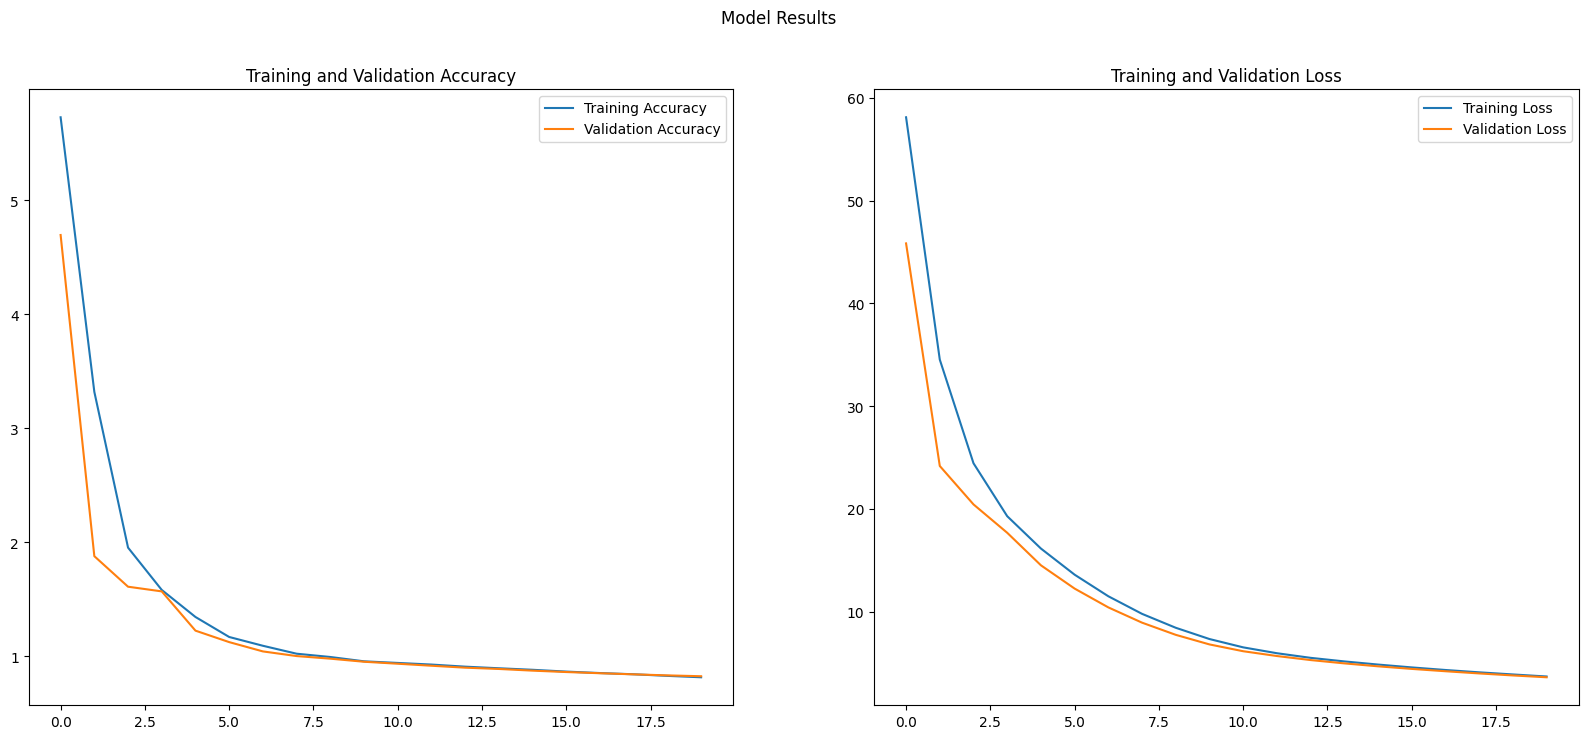

In [63]:
plot_model_performance(history)

Demonstrating the model predictions on those 100 rows we sampled earlier. The model calculates predicted sentiment scores for all rows and sorts them to generate recommendations. These recommendations are not personalized to one specific user but instead represent the general public sentiment surrounding that game, as obtained from its reviews on Steam

In [67]:
import math

# Adjusted function to preprocess new data for prediction
def preprocess_input(
    new_data, label_encoders, multi_label_binarizers, numerical_scaler
):

    # Encoding single-label categorical features
    encoded_categorical = []
    for col, le in label_encoders.items():
        # Transform and reshape each categorical feature to (1, 1)
        encoded_value = le.transform([new_data[col]]).reshape(1, 1)
        encoded_categorical.append(encoded_value)

    # Binarizing multi-label features
    encoded_multi = []
    for col, mlb in multi_label_binarizers.items():
        binarized = mlb.transform([new_data[col]]).reshape(1, -1)
        encoded_multi.append(binarized)

    # Normalizing numerical features
    numerical_df = pd.DataFrame([new_data], columns=numerical_features)
    scaled_numerical = numerical_scaler.transform(numerical_df).reshape(1, -1)

    return encoded_categorical, np.concatenate(encoded_multi, axis=1), scaled_numerical


reverse_sentiment_mapping = {
    1: "Overwhelmingly Negative",
    2: "Very Negative",
    3: "Mostly Negative",
    4: "Negative",
    5: "Mixed",
    6: "Mostly Positive",
    7: "Positive",
    8: "Very Positive",
    9: "Overwhelmingly Positive",
}

true_labels = []
games_info = []
predicted_classes = []
predicted_labels = []

for _, row in df_test.iterrows():
    new_game = {
        "publisher": row["publisher"],
        "developer": row["developer"],
        "app_name": row["app_name"],
        "title": row["title"],
        "id": row["id"],
        "specs": row["specs"],
        "tags": row["tags"],
        "genres": row["genres"],
        "price": row["price"],
        "metascore": row["metascore"],
        "year": row["year"],
        "month": row["month"],
        "day_of_week": row["day_of_week"],
        "early_access": row["early_access"],
    }

    true_labels.append(row["sentiment"])
    games_info.append(new_game)

    encoded_categorical, encoded_multi, scaled_numerical = preprocess_input(
        new_game, label_encoders, multi_label_binarizers, scaler
    )

    inputs = encoded_categorical + [encoded_multi] + [scaled_numerical]

    predictions = model.predict(inputs, verbose=0)
    predicted_class = math.floor(predictions[0][0])
    predicted_class = min(predicted_class, 9)
    predicted_class = max(predicted_class, 1)
    predicted_classes.append(predicted_class)
    predicted_label = reverse_sentiment_mapping[predicted_class]
    predicted_labels.append(predicted_label)

pd.concat(
    [
        pd.DataFrame(games_info).drop(["title", "id"], axis=1),
        pd.Series(true_labels, name="true_sentiment"),
        pd.Series(predicted_classes, name="predicted_sentiment"),
        pd.Series(predicted_labels, name="sentiment_name"),
    ],
    axis=1,
).sort_values(by='predicted_sentiment', ascending=False)

,publisher,developer,app_name,specs,tags,genres,price,metascore,year,month,day_of_week,early_access,true_sentiment,predicted_sentiment,sentiment_name
84,"Brace Yourself Games, Klei Entertainment",Brace Yourself Games,Crypt of the NecroDancer,"[Single-player, Local Co-op, Steam Achievement...","[Rhythm, Rogue-like, Great Soundtrack, Pixel G...","[Action, Indie, RPG]",14.99,87.000000,2015.0,4.0,3.0,False,9,9,Overwhelmingly Positive
99,"Devolver Digital, Croteam",Mommy's Best Games,Serious Sam Double D XXL,"[Single-player, Local Co-op, Steam Achievement...","[Action, Indie, Platformer, Comedy, Shooter, 2...","[Action, Indie]",9.99,83.370000,2011.0,8.0,1.0,False,8,8,Very Positive
44,Electronic Arts,BioWare,Dragon Age: Origins,[Single-player],"[RPG, Fantasy, Story Rich, Multiple Endings, S...",[RPG],19.99,91.000000,2009.0,11.0,4.0,False,8,8,Very Positive
75,Square Enix,Square Enix,WORLD OF FINAL FANTASY,"[Single-player, Steam Achievements, Full contr...","[RPG, JRPG, Anime, Cute, Fantasy, Turn-Based C...",[RPG],39.99,84.020000,2017.0,11.0,1.0,False,8,8,Very Positive
26,Sekai Project,Vifth Floor,Just Deserts,"[Single-player, Steam Achievements, Steam Trad...","[Anime, Strategy, Visual Novel, Dating Sim, In...","[Casual, Indie, Simulation, Strategy]",9.99,76.836667,2016.0,7.0,0.0,False,8,8,Very Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,Dovetail Games- Flight,TakeFlight Interactive,FSX Steam Edition: Final Approach Add-On,"[Single-player, Multi-player, Downloadable Con...",[Simulation],[Simulation],5.99,57.890000,2016.0,10.0,2.0,False,5,4,Negative
61,WB Games,"NetherRealm Studios,QLOC",Injustice 2 - Fighter Pack 2,"[Single-player, Multi-player, Online Multi-Pla...",[Action],[Action],19.99,56.450000,2017.0,11.0,1.0,False,3,4,Negative
79,The_Kiddy,The_Kiddy,Polterheist,"[Single-player, Steam Trading Cards]","[Action, Indie, Simulation, Survival, Horror, ...","[Action, Indie, Simulation]",4.99,47.640000,2017.0,2.0,1.0,False,3,3,Mostly Negative
63,FireFly Studios,FireFly Studios,Stronghold 3 Gold,"[Single-player, Multi-player, Cross-Platform M...","[Strategy, Medieval, City Builder, Simulation,...","[Simulation, Strategy]",29.99,46.960000,2012.0,5.0,4.0,False,3,3,Mostly Negative
